<a href="https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/08/Day_8_Convnet_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boilerplate Convnet example
In this notebook we'll be looking at training a convolutional neural network the [CIFAR 10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR dataset contains relatively low resolution (32x32 pixel) images of 10 distinct categories of objects.

* airplane										
* automobile										
* bird										
* cat										
* deer										
* dog										
* frog										
* horse										
* ship										
* truck

We recommend that you run, examine, and understand all the code before attempting any of the exercises so that they make sense in a broader context.

Thanks to [Algorithmia](https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/) for some of the base code for this example.

## Use a GPU!

This notebook uses the GPU functionality of Pytorch and Google Collab. We need to make sure we are running our operations on the GPU, verify this in you notebook settings at the top. Setting found under:

`Runtime > Change runtime type > Hardware Accelerator -> GPU`

Let's start by installing a package and importing some modules we'll need later.

In [0]:
!pip install torchviz
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time

     |████████████████████████████████| 51kB 2.1MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=d6c2b6047200c1f0420083c2e8488c21df2e8a2c702f8e3de04fd2d2208bec76
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


## Load the data
This dataset happens to be included with pytorch so we can call some pytorch functions to automatically load and parse the data we need to. 

Don't worry too much about the specifics of this part. Data loading, cleaning, and parsing is often taylored to every dataset so functions from one dataset loading don't often directly transfer to another.

In [0]:
# Data set information
image_dims = 3, 32, 32
n_training_samples = 20000 # How many training images to use
n_test_samples = 5000 # How many test images to use
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load the training set
train_set = torchvision.datasets.CIFAR10(
    root='./cifardata', train=True, download=True, transform=transforms.ToTensor())
train_sampler = SubsetRandomSampler(
    np.arange(n_training_samples, dtype=np.int64))

#Load the test set
test_set = torchvision.datasets.CIFAR10(
    root='./cifardata', train=False, download=True, transform=transforms.ToTensor())
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

0it [00:00, ?it/s]

 99%|█████████▉| 169197568/170498071 [00:11<00:00, 18052259.59it/s]

Files already downloaded and verified


Explore the data a bit.  Here are some suggestions.  (If you haven't yet, enable "Automatically trigger code completion suggestions" by first enabling beta features through the beaker icon and then clicking on the relevant option under "tools->preferences->editor")
* Check the shapes of various tensors (note that the training data is stored under `train_set.data`)
* Visualize some of the images in the dataset (you can grab data from the train_set using square brackets).  Sample code below. In the past we've shown you how to use subplots to show many images at once (refer to, e.g., the [assignment 5 notebook](https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/05/assignment05.ipynb) for guidance).

training set input data shape (50000, 32, 32, 3)
Number of training outputs 50000


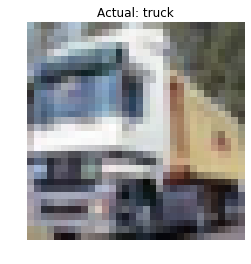

In [0]:
def disp_image(image, class_idx, predicted=None):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(image.transpose(0,2).transpose(0,1))
    plt.axis('off')
    if predicted:
        plt.title("Actual: " + classes[class_idx] + "     Predicted: " + classes[predicted])
    else:
        plt.title("Actual: " + classes[class_idx])
    plt.show()

print("training set input data shape", train_set.data.shape)
print("Number of training outputs", len(train_set.targets))
x, y = train_set[1]
disp_image(x, y)

As another quick example, let's show the number of training data points for each particular class.

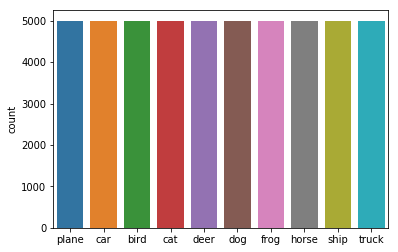

In [0]:
import seaborn as sns

sns.countplot(train_set.targets)
plt.xticks(ticks=range(10), labels=classes)
plt.show()

Add your own explorations as you see fit, or skip ahead for now if you want to spend more time on the convnet stuff.

## Model Architecture
Now that we have the data loaded, let's define our model architecture. As you saw on the previous assignment, convolutional networks have the following basic layer structure.
1. Convolutional layer (this helps detect various image features such as edges and corners)
2. (optional) non-linear tranformation (e.g., ReLu)
3. Max pooling (this reduces the dimensionality of the image and focuses the network on features that are most salient)
4. (repeat 1-3 some number of times)
5. Fully connected layer
6. (repeat (4) some number of times)
7. Output layer

So a typically convnet would look something like this.  Note: that the softmax in the figure below is just the multiclass generalization of the sigmoid we've been using for binary classification.

![](https://miro.medium.com/max/2510/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

For this example we're going to start off by using one convolutional layer to pick up local image features, then a [maxpool operation](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) to reduce our dimensionality a bit, followed by a fully connected layer to perform some logic computations on those features, and finally a fully connected layer to turn those outputs into predictions for the class.  Typically we might have more of each of these sorts of layers, but we are aiming for a simpler network for our first go.

## Software Architecture

In `pytorch` our neural network will be a class.  Here are a few things to remember about how `pytorch` works with neural networks.

* Your neural network class must inherit from `nn.Module`
* You should create the layer objects in the `__init__` method.
* The forward call is where the action happens (data inputs are transformed into outputs of the network).

Consider consulting [the assignment 7 notebook](https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/07/Assignment_07_Companion_Pytorch_Titanic.ipynb) for a refresher.

In [0]:
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self):
        super(MyCNN, self).__init__()
        # layers defined here

        # Make sure you understand what this convolutional layer is doing.
        # E.g., considering looking at help(nn.Conv2D).  Draw a picture of what
        # this layer does to the data.

        # note: image_dims[0] will be 3 as there are 3 color channels (R, G, B)
        num_kernels = 16
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)

        # Make sure you understand what this MaxPool2D layer is doing.
        # E.g., considering looking at help(nn.MaxPool2d).  Draw a picture of
        # what this layer does to the data.

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # maxpool_output_size is the total amount of data coming out of that
        # layer.  We have an exercise that asks you to explain why the line of
        # code below computes this quantity.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

        # Add on a fully connected layer (like in our MLP)
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # we'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # Convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(classes)
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        # Note: that the output will not represent the probability of the
        # output being in each class.  The loss function we will use
        # `CrossEntropyLoss` will take care of convering these values to
        # probabilities and then computing the log loss with respect to the
        # true label.  We could break this out into multiple steps, but it turns
        # out that the algorithm will be more numerically stable if we do it in
        # one go.  We have included a cell to show you the documentation for
        # `CrossEntropyLoss` if you'd like to check it out.
        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # The loss function (which we chose to include as a method of the class, but doesn't need to be)
    # returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

#### Exercise

(a) Draw a picture of this specific network similar to the generic convnet picture shown previously (it doesn't have to be in the exact same format, just try to include similar information).

(b) Explain what is happening in the following line of code (e.g., what is the point of it and where does thsi formula come frome)?

```python
self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))
```

#### Solution

(a) We don't have time to render it for you, but it would include one conv + relu layer, one max pool, a fully connected layer, and finally the outputs.

(b) We needs to know the max pool output size so we can properly size the first fully connected layer.  The max pool output size is based on the number of convolutional kernels, the stride of the max pool (in this case max pool goes moves in steps of 2 along row and column, downsampling the filtered image by a factor of 2 in each direction).  If we didn't set padding=1 in the convolutional layer we would also have to account for edge effects from the convolution.  Here the convolution doesn't change the size of the filtered image. 

### Reading the Docs

Consider reading up on functions in Pytorch that are confusing using the `help` function.

In [0]:
help(nn.CrossEntropyLoss)

## Model Architecture
First let's create our model. Let's also check out a graphical representation of our model (using a library we downloaded earlier) to validate the model looks like we think it should.  This is definitely not the prettiest visualization, and there are lots of things included in here that are related to doing the backward pass (to compute the gradients).  Of particular relevance are the blue nodes, which tell you about the various model parameters and layers.

**Running the below cell will override your model if have already trained one**

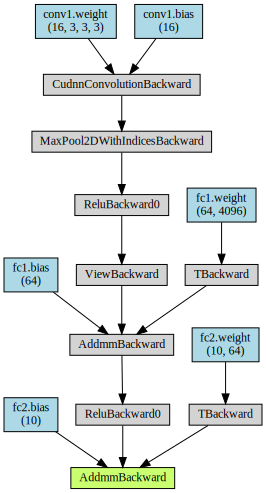

In [0]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

visualize_network(net)

## Training

Next we'll define the settings we'll use for training.  

In the last notebook we mentioned the idea of stochastic gradient descent where we only use a subset of the data to estimate the gradient before doing an update to our model parameters.  In the notebook from last time we used all of our data to compute the gradient (thus we just used regular gradient descent). Although reliable, this method is often slow for larger models.

In this problem we are going to be using a form of **Stochastic Gradient Descent** called **Mini-batch Gradient Descent**.  For mini-batch gradient descent we will use a small batch of data to estimate our gradient and then do an update step (by moving our weights down the negative gradient).  We'll iterate through the whole dataset as a series of mini-batches and perform a step after processing each batch.  This is a much noisier process of weight optimization, but often converges more quickly than the normal gradient descent.

In the code below we define a `DataLoader` function that iterates through the training set (or test set) in increments of `batch_size`. We then define a training wrapper function that will make modifying your model parameters (as we'll do later in this notebook) easier (we don't want to have to keep cutting and pasting code everywhere in this notebook).

In [0]:
# Define training parameters
batch_size = 32
learning_rate = 1e-2
n_epochs = 10
# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=128, sampler=test_sampler, num_workers=2)

def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:

            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

### Now let's train the model!

Here we go!

In [0]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

Epoch 1, Iteration 20	 train_loss: 2.41 took: 0.30s
Epoch 1, Iteration 40	 train_loss: 2.30 took: 0.17s
Epoch 1, Iteration 60	 train_loss: 2.23 took: 0.18s
Epoch 1, Iteration 80	 train_loss: 2.18 took: 0.16s
Epoch 1, Iteration 100	 train_loss: 2.15 took: 0.18s
Epoch 1, Iteration 120	 train_loss: 2.10 took: 0.17s
Epoch 1, Iteration 140	 train_loss: 2.03 took: 0.18s
Epoch 1, Iteration 160	 train_loss: 2.03 took: 0.18s
Epoch 1, Iteration 180	 train_loss: 2.01 took: 0.19s
Epoch 1, Iteration 200	 train_loss: 1.95 took: 0.16s
Epoch 1, Iteration 220	 train_loss: 2.02 took: 0.17s
Epoch 1, Iteration 240	 train_loss: 1.95 took: 0.17s
Epoch 1, Iteration 260	 train_loss: 1.87 took: 0.17s
Epoch 1, Iteration 280	 train_loss: 1.86 took: 0.17s
Epoch 1, Iteration 300	 train_loss: 1.88 took: 0.21s
Epoch 1, Iteration 320	 train_loss: 1.93 took: 0.17s
Epoch 1, Iteration 340	 train_loss: 1.87 took: 0.16s
Epoch 1, Iteration 360	 train_loss: 1.81 took: 0.17s
Epoch 1, Iteration 380	 train_loss: 1.84 took: 0.1

For this problem the speedup of using a GPU is not as great as it would be for other problems (here the speedup is 2-3x).  Generally the bigger the network is (e.g., bigger images) the greater the speedup.  If you want to play around with this on your own, go the model architecture section and change the device variable to "cpu".

## Testing
Lets check the outputs of our network. First Let's plot the loss of the network over time to see if any learning actually occured.

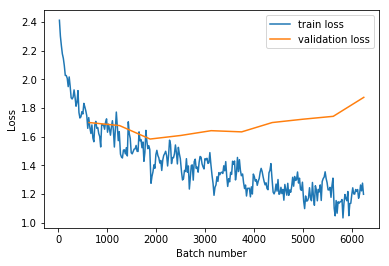

In [0]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

#### Exercise

Interpret what is happening in these curves.  Why is the training curve sampled so much more often (hint: look at the train_model function)?  Why is the training loss noisier (hint: again, look at the train_model function)?  What do the shapes of the curves say about how the model training is going (i.e., is everything going great, are we overfitting?)?

#### Solution

The training loss is evaluated after each mini batch so it is sampled more densely.

The training loss is evaluated only on the elements of the mini-batch (32 images), therefore it is much more subject to the random variation in the datta than the validation loss that is computed over the entire validation set.

These curves show that overfitting is occurring since the trianing loss is going down while the validation loss stays constant (or maybe goes up a bit).

### Showing Model Predictions

For more subjective santiy-checking, we can plot some images and see what our network predicts vs the ground truth label.

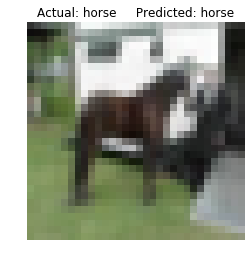

In [0]:
def examine_label(idx):
    image, label = test_set[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    disp_image(image, label, prediction)

examine_label(20)

## Computing Accuracy

The plots of the losses over time give us a sense of how the network is learning.  The losses themselves, however, may not provide a super accurate idea of how the network is actually doing at its task (predicting the correct labels).  We'll do it for the training set.

In [0]:
n_correct = 0
n_total = 0
for i, data in enumerate(train_loader, 0):
    # Get inputs in right form
    inputs, labels = data
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    # Forward pass
    outputs = net(inputs)
    n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
    n_total += labels.shape[0]
print("Training accuracy is", n_correct/n_total)

Training accuracy is 0.60415


### Exercise

Adapt this code so that it computes the accuracy on the test set.  Hint: consider factoring this out into a function to make it more flexible.  If you create a function, you'll want to pass in `net` and `loader` as inputs.

#### ***Solution***

In [0]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))

Train accuracy is 0.60415
Test accuracy is 0.4392


## Model Visualization

There are some really cool visualizations you can create based on your neural network (e.g., [here](https://mc.ai/feature-visualisation-in-pytorch%E2%80%8A-%E2%80%8Asaliency-maps/)).  You saw some of them in the assignment when you looked at the convnet.js examples.  We won't do anything nearly that fancy.  For now, let's just look at convolutional kernels learned by our model.

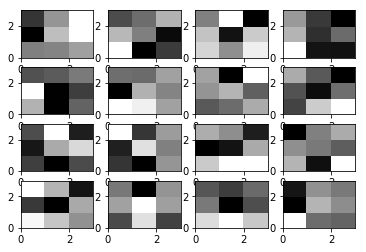

In [0]:
plt.subplots(4, 4)
for i in range(net.conv1.weight.shape[0]):
    plt.subplot(4, 4, i+1)
    kernel = net.conv1.weight[i].cpu().detach().numpy()
    im = kernel.mean(axis=0)
    plt.pcolor(im, cmap='gray')
plt.show()

There's not really all that much to see here.  These look like some edge filters.  Maybe if we use a 5 by 5 kernel they will be more interesting?

Nick Steelman made some fancy visualizations for this network along the lines of the gradient activations we saw in the convnet.js example.  For this super small network, they're not really all that interpretable, but here they are in case you are interested.

Please don't get hung up on trying to interpret these.  We will be giving more guidance on visualizing network features for the project.

Explanation of images from left to right:

1. Gradient of the network towards ground truth label
2. Gradient of the network towards ground truth label overlayed with image
3. Original image
4. Gradient of the network towards predicted label overlayed with image
5. Gradient of the network towards predicted label
6. Precentage difference between the true and predicted gradients
7. What pixels the network should pay more attention to fix this error
8. What pixels the network should pay less attention to fix this error

![](https://raw.githubusercontent.com/mlfa19/assignments/master/Module%201/08/conv_net_viz.png)

## Model Iteration

### Exercise

At this point, try to change your model and see what happens (not necessarily to improve its performance). Here are some possibilities.

* Change the size of some layer to either increase or decrease model complexity.
* Change the activation function in the network to sigmoid or some other function.
* Change the batch size.
* Increase or decrease the number of epochs.

***Tip: when making these changes, consider modifying your neural network class to allow for whatever you are changing to be customized, rather than just hardcoding new values*** For example, if I wanted to try changing the number of convolutional kernels, I might modify my `__init__` function to take this number as a new input (see solution below for details of this example).

Run your new model, compare the performance with the default network, and visualize the model.

#### ***Solution***

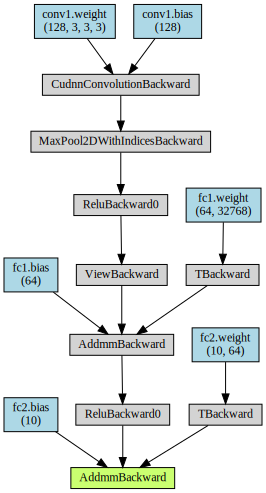

In [0]:
# ***Solution***
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self, num_kernels):
        super(MyCNN, self).__init__()
        # layers defined here

        # Make sure you understand what this convolutional layer is doing.
        # E.g., considering looking at help(nn.Conv2D).  Draw a picture of what
        # this layer does to the data.
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)

        # Make sure you understand what this MaxPool2D layer is doing.
        # E.g., considering looking at help(nn.MaxPool2D).  Draw a picture of
        # what this layer does to the data.

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # maxpool_output_size is the total amount of data coming out of that
        # layer.  Explain why the line of code below computes this quantity.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

        # Add on a fully connected layer (like in our MLP)
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # we'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # Convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(classes)
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        # Note: that the output will not represent the probability of the
        # output being in each class.  The loss function we will use
        # `CrossEntropyLoss` will take care of convering these values to
        # probabilities and then computing the log loss with respect to the
        # true label.  We could break this out into multiple steps, but it turns
        # out that the algorithm will be more numerically stable if we do it in
        # one go.  We have included a cell to show you the documentation for
        # `CrossEntropyLoss` if you'd like to check it out.
        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # The loss function (which we chose to include as a method of the class, but doesn't need to be)
    # returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

# Initialize the model, loss, and optimization function
net = MyCNN(128)
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)
# visualize the model
visualize_network(net)

In [0]:
# ***Solution***
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

Epoch 1, Iteration 20	 train_loss: 5.39 took: 0.31s
Epoch 1, Iteration 40	 train_loss: 2.24 took: 0.21s
Epoch 1, Iteration 60	 train_loss: 2.21 took: 0.20s
Epoch 1, Iteration 80	 train_loss: 2.06 took: 0.19s
Epoch 1, Iteration 100	 train_loss: 2.03 took: 0.19s
Epoch 1, Iteration 120	 train_loss: 1.94 took: 0.19s
Epoch 1, Iteration 140	 train_loss: 1.95 took: 0.19s
Epoch 1, Iteration 160	 train_loss: 1.89 took: 0.20s
Epoch 1, Iteration 180	 train_loss: 1.93 took: 0.19s
Epoch 1, Iteration 200	 train_loss: 1.87 took: 0.21s
Epoch 1, Iteration 220	 train_loss: 1.79 took: 0.19s
Epoch 1, Iteration 240	 train_loss: 1.86 took: 0.20s
Epoch 1, Iteration 260	 train_loss: 1.81 took: 0.18s
Epoch 1, Iteration 280	 train_loss: 1.78 took: 0.19s
Epoch 1, Iteration 300	 train_loss: 1.76 took: 0.19s
Epoch 1, Iteration 320	 train_loss: 1.78 took: 0.20s
Epoch 1, Iteration 340	 train_loss: 1.75 took: 0.20s
Epoch 1, Iteration 360	 train_loss: 1.78 took: 0.19s
Epoch 1, Iteration 380	 train_loss: 1.68 took: 0.1

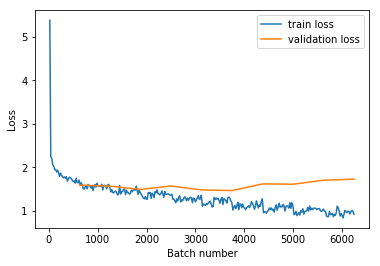

Train accuracy is 0.71065
Test accuracy is 0.4956


In [0]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))